# Simulation of an idealised disc galaxy

This tutorial will take you through the process of generating idealised disc simulations:

- generation of initial conditions with **DICE**

- running different flavours of RAMSES (hydro, RHD)

- using different star formation and feedback (supernova, AGN) subgrid models

Through the tutorial, you will learn how to edit the **Makefile** depending on the physical modules included, and how to adapt the **namelist** accordingly, using meaningful values for the parameters of the subgrid models. Finally, you will also learn how to use **yt** and **ffmpeg** to visualize the RAMSES outputs.

## 1. Prerequisites

- a `fortran compiler` to compile RAMSES

- some version of `MPI` to run RAMSES in parallel

- `python3` in a `Jupyter notebook`, including the following packages :`numpy`, `astropy`, `matplotlib`

### Specific modules, codes and packages needed for this tutorial

- `DICE`

- a `C compiler`, `GSL` and `FFTW3` to compile and use DICE

- `yt`

- `ffmpeg`

### Memory and CPU resources requirement

If you want to run the RAMSES simulations from this tutorial on your laptop, we recommand that you have access (at minimum) to the following resources:

- ? Gb of memory

- ? cores

**Note:**

Please refer to the **Instructions to get started on the CBP machine** or **Instructions to get started on your laptop** section according to your needs, and make sure that you load the modules needed on the machine you are using before going forward (namely GSL, fftw, and fortran and C compilers with e.g. GCC).

### 1.1 Getting DICE

In this tutorial, we will use the [DICE](https://bitbucket.org/vperret/dice/src/master/) initial conditions generator to create galaxy disk initial conditions (ICs).

**Laptop users**

Begin by going to the [DICE](https://bitbucket.org/vperret/dice/src/master/) website and follow the [instructions](https://bitbucket.org/vperret/dice/wiki/Compile%20&%20Install) there to download and install the code. Depending on your C compiler version, you may need the following 'extra' parameters with cmake when installing:

```bash
cmake .. -DCMAKE_C_FLAGS="-fcommon"
```
---

**CBP users**

Load the following modules --**Add here the commands needed to load / get fftw and gsl on the CBP**:
```bash
module load ???????????????
```

You can directly go to the "Compile & install section" of the [DICE instructions webpage](https://bitbucket.org/vperret/dice/wiki/Compile%20&%20Install), or simply follow the instructions below.

---

Install DICE with:
```bash
git clone https://bitbucket.org/vperret/dice
cd dice
mkdir build
cd build
cmake ..
make
make install
```
If you encounter any problem, please refer to the [DICE instructions for installation](https://bitbucket.org/vperret/dice/wiki/Compile%20&%20Install).

After installation (cmake, make, and make install), you should obtain a `dice` directory which contains the executable here `dice/build/bin/dice`. This will be used to generate the initial conditions read by RAMSES.

### 1.2 Getting yt

[yt](https://yt-project.org) is an open-source python package that we will use for analyzing and visualizing RAMSES data (it is also compatible with data from other astrophysical codes). To download and install the yt code, we recommend the use of conda:

```bash
conda install -c conda-forge yt
```

(Alternatively, you may also use pip with the command: `python -m pip install --user yt`)


### 1.3 Getting ffmpeg

[ffmpeg](https://www.ffmpeg.org) will be used for processing and assembling images into a movie. To download ffmpeg and install ffmpeg, do as follows:

```bash
git clone https://git.ffmpeg.org/ffmpeg.git ffmpeg
cd ffmpeg
./configure
make
make install
```

(Alternatively, you can also directly download the source code and executable from the webpage, or run `apt install ffmpeg`)

## 2. Running RAMSES with DICE ICs

### 2.1 Running DICE to create the ICs

Using the DICE executable, you can now run DICE with the dwarf galaxy configuration files found in `ramses-tutorials/Idealised-Disc-Galaxy/ICs/dwarf_galaxy/`. This generates ICs that RAMSES can read to run a simulation of an isolated galaxy. The RAMSES namelist needs to know where the ICs are stored, so we will generate the ICs into that same sub-subfolder with (it should take ~2 min.): 

```bash
cd ICs/dwarf_galaxy
/path/to/dice/build/bin/dice dwarf_galaxy.config
```

You should now have 6 additional files in that folder: `dwarf_galaxy.params.rzN` (N=1-5) and `dwarf_galaxy.g2`. Each `dwarf_galaxy.params.rzN` includes the properties of one of the 5 galaxy components (halo, stellar disk, gaseous disk, stellar bulge and stellar spheroid, see details in dwarf_galaxy.params). `dwarf_galaxy.g2` is a binary file, that corresponds to the ICs used by RAMSES to run the simulation of this dwarf galaxy.

We will now run and analyze a RAMSES simulation with this fiducial dwarf galaxy. Later on, feel free to play with the DICE parameter files (.config and .params) to generate your own galaxy ICs with different properties (e.g. halo and stellar mass, gas to stellar mass fraction, disc thickness etc.).

### 2.2 Running RAMSES to get an isolated galaxy simulation

For running with the DICE ICs, RAMSES needs to be compiled with the DICE patch. For this, go to the directory in which you cloned RAMSES and type: 

```bash
cd ramses/bin
make clean
make NDIM=3 MPI=1 PATCH=../patch/init/dice/ EXEC=ramses-dice
```

After the code has compiled, we will run a $~10^{10} \ M_{\odot}$ halo with $~50$ pc resolution, star formation and supernovae feedback (but no radiation), so this simulation takes some time to get to the end goal of $250 \ {\rm Myr}$ of galaxy disk evolution. Still, the first outputs will be written shortly, and you will be able to continue the tutorial while the simulation is running. To start the simulation, go back to the `dwarf_galaxy/` directory, into the sub-directory `dwarf_galaxy_run/` and run RAMSES as follows:
```bash
cd dwarf_galaxy_run
mpirun -np 8 ../path/to/ramses/bin/ramses-dice3d setup.nml > run.log &
```
In this example we are using 8 cores, you might need to use less if you are running this locally, and you should use more if you have access to more. 
The simulation will eventually return ~50 outputs and two movie directories. Also, the command is run in the background (with `&`). Should you want to stop the simulation, type `fg` in the terminal, which will bring back the run to the foreground, and use `ctrl-C`. 

You can check the evolution of the simulation through the log file as the run progresses, for example with (type `ctrl-C` to stop):

```bash
tail -f run.log
```

Congratulations, you just made a RAMSES idealised galaxy simulation! You can then play with increasing the resolution, using more sophisticated models for star formation or feedback in your namelist file (`setup.nml`), and this tutorial will show you some examples of how to do so. 

For descriptions of the available parameters, see the [RAMSES documentation](https://ramses-organisation.readthedocs.io/en/latest/). You can also generate different galaxy disk ICs with DICE. Start from the configuration files coming with this tutorial and refer to the DICE documentation for an overview of the parameters and what they do. 

Now that you have a few outputs, we can execute the notebook cells below to do some visualisation.

## 3. Visualizing the outputs

### 3.1 Maps and plots with [yt](https://yt-project.org/)

In [1]:
# Import the relevant modules for reading RAMSES outputs and visualising them
import yt
import numpy as np
from matplotlib import pyplot as plt
yt.set_log_level(0)

In [2]:
# Load RAMSES snapshot with Yt
RHD=False # Set to true if running RAMSES-RT -- this is for later.
snap=9 # Snapshot number to look at -- You need to change this as you get more outputs!!!
snapstr = "%05d" % snap
path='./dwarf_galaxy_run/'
if RHD: path='./dwarf_galaxy_rhd_run/'
ds = yt.load(path+'output_'+snapstr+'/info_'+snapstr+'.txt')

In [3]:
# Show the available variables
#sorted(ds.field_info)

The total gas mass is  139654600.67260376 Msun



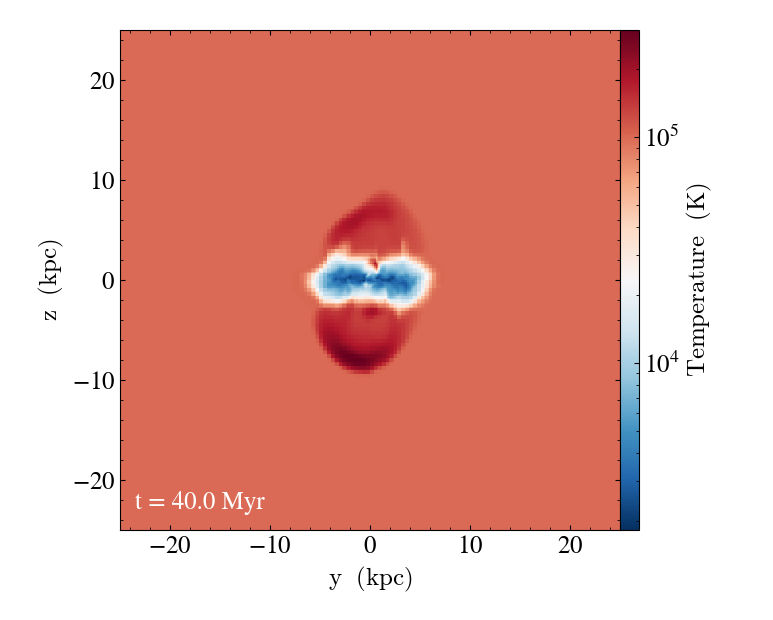


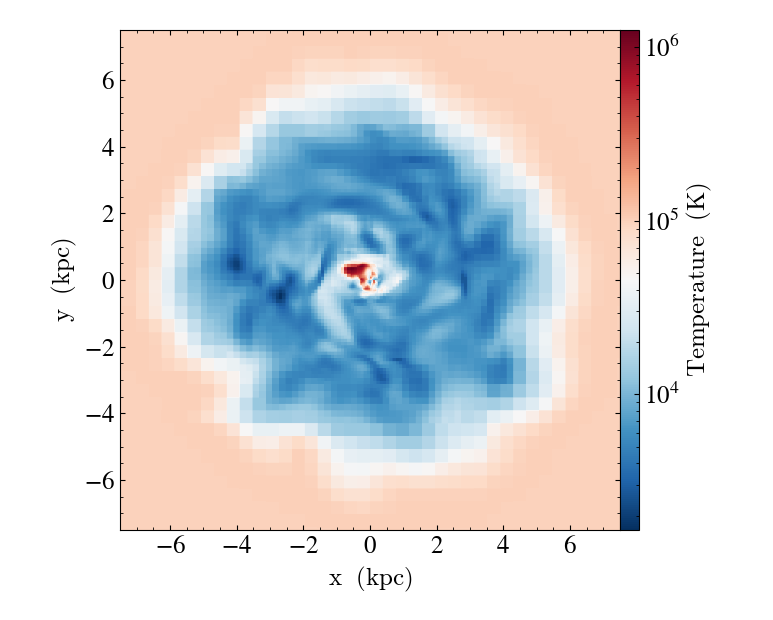


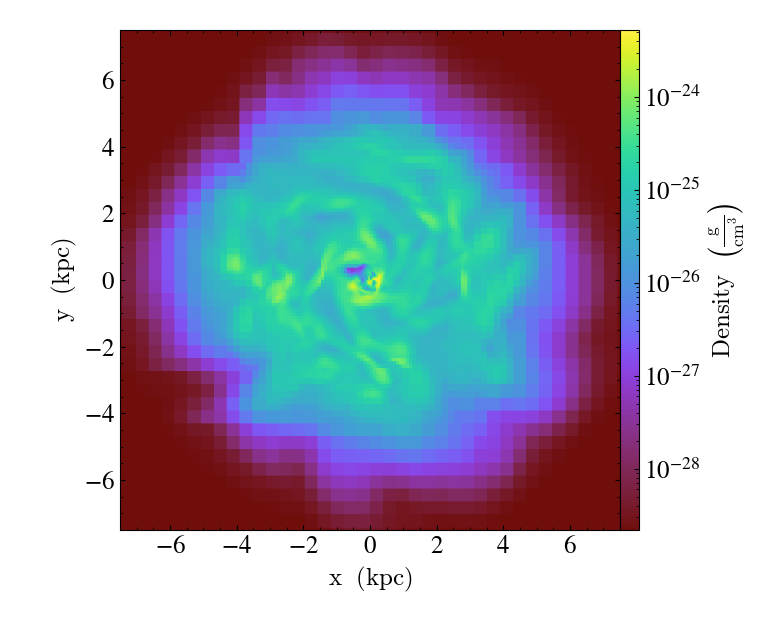


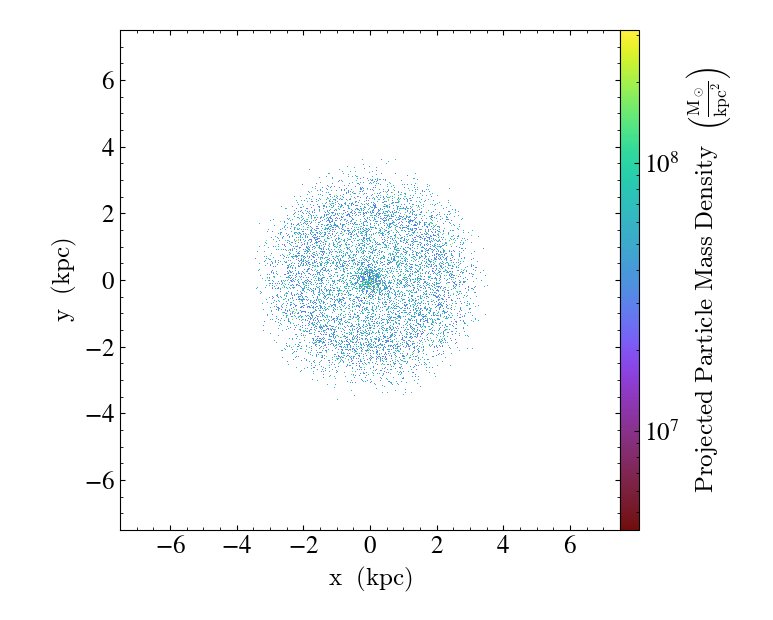

In [4]:
# Show projection maps
ad=ds.all_data()
m_tot = np.sum(ad['density']*ad['dx']**3)
print("The total gas mass is ",m_tot.in_units('Msun'))
time_Myr = ds.current_time.in_units('Myr')

# projection of the full box in temperature, face-on
p = yt.ProjectionPlot(ds, 'x', 'temperature',weight_field='density')
p.annotate_timestamp()
p.set_cmap(('temperature'), "RdBu_r")
p.set_figure_size(5)
p.show()

# zoomed-in projection of temperature, density, and stars
p = yt.ProjectionPlot(ds, 'z', 'temperature',weight_field='density',width=(15,'kpc'))
p.set_cmap(('temperature'), "RdBu_r")
p.set_figure_size(5)
p.show()

p = yt.ProjectionPlot(ds,'z', 'density',width=(15,'kpc'), method="max")
p.set_unit('density', 'g/cm**3')
p.set_figure_size(5)
p.show()

p = yt.ParticleProjectionPlot(ds, 2, [("star", "particle_mass")], width=(15,'kpc'), density=True)
p.set_unit(("star", "particle_mass"), "Msun/kpc**2")
p.set_figure_size(5)
p.show()

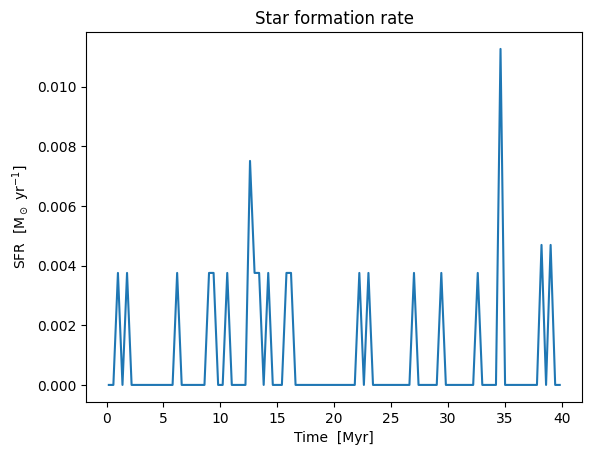

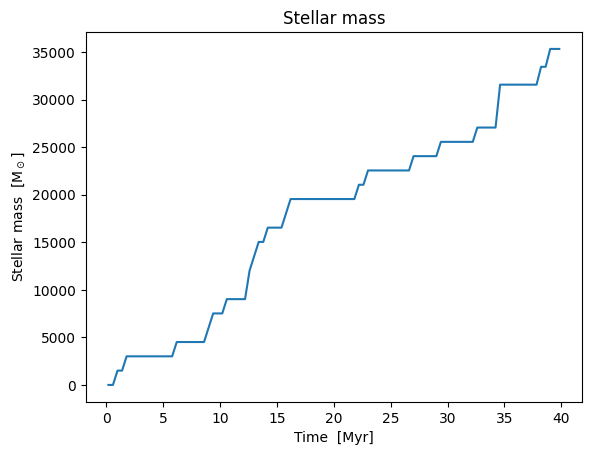

In [5]:
# Plot star formation history.
# You need to use an output with star particles for this to work -> change the value of snap!
plt.ion() # So as to show plots
ad = ds.all_data()
masses = ad['star', 'particle_mass'].in_units('Msun')
formation_time = ad['star', 'particle_birth_time'].in_units('yr')
time_yr = ds.current_time.in_units('yr')
time_range = [-100, time_yr.v] # years
n_bins = 100
hist, bins = np.histogram(formation_time, bins=n_bins, range=time_range,)
inds = np.digitize(formation_time, bins=bins)
time = (bins[:-1] + bins[1:])/2
sfr = np.array([masses[inds == j+1].sum()/(bins[j+1]-bins[j])
                for j in range(len(time))])
mass = np.array([masses[inds == j+1].sum()
                for j in range(len(time))])
mass= np.cumsum(mass)
# SFR plot
plt.plot(time/1e6, sfr)
plt.title('Star formation rate')
plt.xlabel('Time  [Myr]')
plt.ylabel(r'SFR  [M$_\odot$ yr$^{-1}$]')
plt.show()

# Plot of stellar mass formed
fig=plt.figure()
plt.plot(time/1e6, mass)
plt.title('Stellar mass')
plt.xlabel('Time  [Myr]')
plt.ylabel(r'Stellar mass  [M$_\odot$]')
plt.show()

### 3.2 Making movies

The RAMSES simulation namelist contains MOVIE_PARAMS (see also [the documentation](https://ramses-organisation.readthedocs.io/en/latest/wiki/Movies.html) for details), which tells the code to generate binary files with short time intervals showing face-on and edge-on projections of gas density, temperature, and stars.

The first cell below reads those binary files and creates .png images out of them, each with the density, temperature, and stars superimposed.

The second cell then calls ffmpeg to squeeze all those pngs into one .mp4 movie file. For that second cell to work, you need to have ffmpeg installed.

In [ ]:
# Read binary movie frames and make .png images
import os
import glob
import numpy as np
from scipy.io import FortranFile
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

mov_proj = 1 # Movie projection (1=face-on, 2=edge-on)     ####################CHANGE THIS FOR DIFFERENT PROJECTION

plt.ioff() # So as not to show plots
#plt.ion() # So as to show plots
fig = plt.figure(frameon=False)
nx = 500
ny = 500
nypic=ny  #int(ny*0.6)
plt.subplots_adjust(left=0., bottom=0.,
                    right=1.+1.0/nx, top=1.+1.0/nypic,
                    wspace=0., hspace=0.)
fig.set_size_inches(nx/100.*.7,nypic/100.*.7)

#As defined via movie_vars_txt in setup.nml
quants = {
    "temp": {
        "name": "temp",
        "data": np.array([]),
        "min": 1e10,
        "max": -1e10,
    },
    "dens": {
        "name": "dens",
        "data": np.array([]),
        "min": 1e10,
        "max": -1e10,
    },
    "stars": {
        "name": "stars",
        "data": np.array([]),
        "min": 1e10,
        "max": -1e10,
    }
}

if RHD:
    quants.update({
    "Fp1": {
        "name": "Fp1",
        "data": np.array([]),
        "min": 1e10,
        "max": -1e10,
    }}
    )

d_cmap=matplotlib.cm.viridis

cmap = matplotlib.cm.bone
stars_cmap = cmap(np.arange(cmap.N))
stars_cmap[:,-1] = np.linspace(0, 1, cmap.N)
stars_cmap = ListedColormap(stars_cmap)

cmap = matplotlib.cm.RdBu_r
temp_cmap = cmap(np.arange(cmap.N))
temp_cmap[:,-1] = np.linspace(0, 1, cmap.N)
temp_cmap = ListedColormap(temp_cmap)

cmap = matplotlib.cm.cividis
fp_cmap = cmap(np.arange(cmap.N))
fp_cmap[:,-1] = np.linspace(0, 1, cmap.N)
fp_cmap = ListedColormap(fp_cmap)

movie_path = '%s/movie%d/'%(path,mov_proj)
png_dir = '%s/pngs'%(path)
try:
    os.mkdir(png_dir) # Create directory to store movie frames in png files
except FileExistsError:
    do_nothing=True
all_ok = True

# Figure out the number of frames for the movie
searchstring = '%s/info_'%(movie_path)
frames = glob.glob(searchstring+'*') # Frame strings
i_frames = [ int(str[len(searchstring):len(searchstring)+4]) for str in frames ]
i_frames = sorted(i_frames)         # Sort them
imin = i_frames[0]
imax = i_frames[len(i_frames)-1]

# Loop over the movie frames and generate .png images
for i in range(imin,imax+1):
    # Read the info file:
    info = open(f"{movie_path}info_{str(i).zfill(5)}.txt").readlines()
    time_sec=0.0
    time_sec = float(info[8].split("=")[-1].strip())
    unit_l =   float(info[15].split("=")[-1].strip())
    unit_d =   float(info[16].split("=")[-1].strip())
    unit_t =   float(info[17].split("=")[-1].strip())
    time_myr = time_sec*unit_t/3.156e13
    
    # Load in the data
    for q in quants:
        fname = f"{quants[q]['name']}_{str(i).zfill(5)}.map"
        ffile = FortranFile(f"{movie_path}{fname}")
        [time, fdw, fdh, fdd] = ffile.read_reals('d')
        [frame_nx, frame_ny] = ffile.read_ints()
        data = np.array(ffile.read_reals('f4'), dtype=np.float64)
        try: 
            quants[q]["data"] = data.reshape(frame_nx,frame_ny)
            quants[q]["min"] = quants[q]["data"][quants[q]["data"] > 0].min()
            quants[q]["max"] = quants[q]["data"][quants[q]["data"] > 0].max()
            quants[q]["data"][quants[q]["data"] < quants[q]["min"]] = 1e-5 * quants[q]["min"]
        except ValueError:
            all_ok = False
        f, axs = plt.subplots(1,1,figsize=(7.5,7.5),sharex=True,sharey=True)
    plt.subplots_adjust(left=0, right=1.0, top=1.0, bottom=0)
    axs.imshow(np.log10(quants["dens"]["data"]),vmin=-6,vmax=2,cmap=d_cmap,aspect='auto',interpolation='none')
    if RHD:
        axs.imshow(np.log10(quants["Fp1"]["data"]),vmin=-6,vmax=2,cmap=fp_cmap,aspect='auto',alpha=0.5)
    else:
        axs.imshow(np.log10(quants["temp"]["data"]),vmin=4.5,vmax=6.5,cmap=temp_cmap)
        axs.imshow(np.log10(quants["stars"]["data"]),vmin=-5,vmax=-2,cmap=stars_cmap,alpha=0.5)
    plt.axis("off")
    # Text showing simulation time
    axs.text(0.97, 0.03,'%.2f Myr'%(time_myr), fontsize=15,transform=axs.transAxes
             , verticalalignment='bottom', horizontalalignment='right', color='white')
    # Bar showing length scale
    frame_width_kpc = fdw*unit_l/3.08e21
    rect = mpatches.Rectangle((0.055,0.03),10./frame_width_kpc,0.002,color='white',transform=axs.transAxes)
    axs.add_patch(rect)
    axs.text(0.055, 0.01+15./frame_ny, ('%d kpc'%(10)),
            verticalalignment='bottom', horizontalalignment='left',
            transform=axs.transAxes, color='white', fontsize=15. )
   
    # Store frame in png file
    filename = '%s/frame_%d_%05d.png'%(png_dir,mov_proj,i)
    print(filename)
    f.savefig(filename, dpi=100)

In [ ]:
# Run ffmpeg to make a .mp4 out of the .png frames
import subprocess
movie_filename = '%smovie%d.mp4'%(path,mov_proj)
frames = '%spngs/frame_%d_%%*.png'%(path,mov_proj)
fps=50.
speed=60.
quality=23
print("Calling ffmpeg! Output: {mov}".format(mov=movie_filename))
print("{binffmpeg} -i {input}\
                     -y -vcodec h264 -pix_fmt yuv420p\
                     -r {fps} -filter:v 'setpts={speed}*PTS'\
                     -crf {quality} {output}".
                    format(binffmpeg='ffmpeg', input=frames,
                           fps=fps, speed=speed/fps,
                           quality=quality, output=movie_filename))
subprocess.call("{binffmpeg} -i {input}\
                     -y -vcodec h264 -pix_fmt yuv420p\
                     -r {fps} -filter:v 'setpts={speed}*PTS'\
                     -crf {quality} {output}".
                    format(binffmpeg='ffmpeg', input=frames,
                           fps=fps, speed=60./fps,
                           quality=quality, output=movie_filename), shell=True)
print('####################################################################')
print('-----------Your new movie is here: ', movie_filename)
print('####################################################################')

## 4. Let's play with RAMSES!

### 4.1 RHD run
Now you can do the same run with radiation-hydrodynamics (RHD) and include ionising radiation from stars. 

Let's take a moment to compare the setup of the RHD (`dwarf_galaxy_rhd_run/`) to the previous, purely hydro simulation (`dwarf_galaxy_run/`). Every RAMSES simulation has a namelist, here called `setup.nml`, which lists a number of parameters and their value. For more details about how the namelist works, see also [the RAMSES documentation here](https://ramses-organisation.readthedocs.io/en/latest/wiki/Runtime_Parameters.html).   

The namelist is split in several parameter sections, all starting with the symbol `&`. 
For example, in order to include radiative transfer (RT), we need to turn on radiative transfer with `rt=.true.` in the `&RUN_PARAMS` section, and set RT-specific params in the `&RT_PARAMS` and `&RT_GROUPS` sections:

`&RUN_PARAMS`
```
`rt=.true.`
```

and

`&RT_PARAMS`
```
rt_pressboost=1d0
rt_output_coolstats=.true.
rt_star=.false.                  ! Release radiation from stars
sedprops_update=5
rt_flux_scheme='glf'
rt_courant_factor=0.8		! courant number for RT timesteps
rt_c_fraction=0.001	        ! fraction of actual lightspeed set to RT lightspeed
rt_nsubcycle=500
rt_otsa=.true.                  ! On-the-spot approximation
sed_dir='../../SED/bc03/'
```

`&RT_GROUPS`
```
kappaAbs = 1000,  1000, 1000
kappaSc =  0.0,   0.0,   0.0
groupL0  = 13.60, 24.59, 54.42
groupL1  = 24.59, 54.42, 0.0
```

You can access the list of all these parameters in their respective ramses modules, `ramses/amr/amr_parameters.f90` for `&RUN_PARAMS`, `ramses/rt/rt_parameters.f90` for `&RT_PARAMS`, and so on.

Before running the RHD simulation, you first need to compile RAMSES with the RHD options of three radiation groups and 3 ionisation fractions (xHII, xHeII, and xHeIII): 
```bash
cd ramses/bin
make clean
make NDIM=3 MPI=1 PATCH=../patch/init/dice/ RT=1 NGROUPS=3 NIONS=3 EXEC=ramses-dice-rhd
```

After the code has compiled, you can go to the sub-directory named `dwarf_galaxy_rhd_run/` and run RAMSES as follows:
```bash
cd dwarf_galaxy_rhd_run
mpirun -np 8 ../ramses/bin/ramses-dice-rhd3d setup.nml > run.log &
```

You can then use the visualization routines above to look at the outputs from the RHD run. Just remember to change ```path``` when loading the RAMSES outputs with yt. You can also use the cells above to make a movie including the ionising radiation flux.

### 4.2 AGN feedback

In both the hydro and the RHD directories, the prepared namelist file includes a SINK_PARAMS namelist for including the a black hole of mass $10 \times 10^7 \ M_{\odot}$ in the initial conditions, as well as thermal AGN feedback. 

`&SINK_PARAMS`
```
! General switches
smbh=.true.                 ! turns sinks into SMBH
agn=.true.                  ! enables AGN feedback
...

! Seeding masses
...

! Accretion
...

! Merging
...

! Feedback
...
```

You can activate this by setting sink=.true. and clumpfind=.true. in your namelist:

`&RUN_PARAMS`
```
sink=.true.
clumpfind=.true.
```

Again, you can visualize and analyze the simulation produced with yt. 

### 4.3 Star formation

We will now focus on the star formation models, whose parameters are set in the `&SF_PARAMS` section of the namelist. The full list of parameters available can be found in `ramses/hydro/read_hydro_parameters.f90`, and their default values are defined in `ramses/amr/amr_parameters.f90`. The details of the models presented below can be found in `ramses/pm/star_formation.f90`.

Star formation in RAMSES occurs in three steps:

1. Restrict star formation to specific gas cells.

2. Define with what efficiency the gas mass will be converted into stars.

3. Compute the number of stellar particles that will be formed (i.e. particles representing single stellar populations). 

In the current version of RAMSES, there are 7 star formation models, and more might be implemented later. They differ in the selection of star forming cells (step 1) and in the computation of the star formation efficiency (SFE, step 2). For step 3, star formation models are based on the Schmidt law to compute how many stars will be created, following
$$ \dot{\rho}_\star = \epsilon_{ff} \frac{\rho}{t_{ff}}, $$

with:\
$\dot{\rho}_\star$ the rate of conversion of gas mass into stars,\
$\epsilon_{ff}$ the SFE (conversion efficiency),\
$\rho$ the density of the gas,\
$t_{ff}=\left[3\pi / 32G\rho \right]^{1/2},$ the free-fall time, with $G$ the gravitational constant. 

So far, we used a simple star formation prescription, in which stars form with a constant efficiency of $\epsilon_{ff}$=`eps_star`= 0.1 (the default value is 0, i.e. no star formation). We restricted star formation to cells with a hydrogen density $n_H >$`n_star`=0.5 (the default value is 0.1 H/cc). We also used a polytropic equation of state with a temperature floor `T2_star`=10 K (the default is 0, i.e. no polytrope).

`&SF_PARAMS`
```
n_star=0.5                      ! Density threshold for star formation
eps_star=0.1                    ! Star formation efficiency (% of free-fall time)
T2_star=10                      ! Cooling floor (in Kelvin)
```

**Beyond the basic star formation model**

The default namelist uses `sf_virial=.false.`. If you use `sf_virial=.true.`, subgrid turbulence will be modelled, allowing for more complex star formation prescriptions via `sf_model`=0-5.

`sf_model`=0: constant $\epsilon_{ff}$, Schmidt law ([Schmidt 1959](https://ui.adsabs.harvard.edu/abs/1959ApJ...129..243S))\
`sf_model`=1: variable $\epsilon_{ff}$, multi-free fall model from [Federrath and Klessen 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...761..156F) and [Krumholz & McKee 2005](https://ui.adsabs.harvard.edu/abs/2005ApJ...630..250K/abstract)\
`sf_model`=2: variable $\epsilon_{ff}$, multi-free fall model from [Federrath and Klessen 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...761..156F) and [Padoan & Nordlund 2012](https://ui.adsabs.harvard.edu/abs/2011ApJ...730...40P/abstract)\
`sf_model`=3: constant $\epsilon_{ff}$, adds a virial criterion to step 1 (star formation in gravitationally bound regions)\
`sf_model`=4: variable $\epsilon_{ff}$, simple law of star formation from [Padoan 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...759L..27P)\
`sf_model`=5: constant $\epsilon_{ff}$, adds a(nother) virial criterion to step 1 ([Hopkins 2013](https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.2647H))

To use any of these models, you therefore need to add `sf_virial=.true.` and `sf_model` (and its value) to the namelist.

`&SF_PARAMS`
```
sf_virial=.true.                ! Star formation model with subgrid turbulence
sf_model=0                      ! Star formation model (as listed above), number between 0 and 5
```

These 6 prescriptions model subgrid turbulence, so RAMSES additionally needs one more hydro variable. This means that you have to re-compile RAMSES after adding 1 to `NVAR` in the Makefile. This extra-variable corresponds to a passive scalar, which will be advected if a decay time is defined in the namelist (if `sf_tdiss`$>0$, 0 by default).

*Note:* The subgrid turbulence only has an indirect effect on star formation for models with a constant SFE (`sf_model`=0,3 and 5), but directly impacts the SFE for models with a variable SFE (`sf_model`=1,2 and 4)

**Exercises**

Now that you know better about the star formation subgrid models, test them out!

First, using the same star formation model as before:

1. Change the star formation threshold density to $n_\star=100$ and see how it affects the star formation history. Why is the burstiness of the SFR changing? 
2. What about changing the star formation efficiency $\epsilon_\star$? How does it impact the total stellar mass?

Then, let's compare the star formation history with a constant versus variable SFE.

3. How does star formation vary when following a Schmidt law with a constant efficiency compared to the multi-free fall model from Padoan & Nordlund?

### 4.4 Supernova feedback

Let's now turn to the supernova feedback models, whose parameters are set in the `&FEEDBACK_PARAMS` section of the namelist. The full list of parameters available can be found in `ramses/hydro/read_hydro_parameters.f90`, and their default values are defined in `ramses/amr/amr_parameters.f90`. The details of the models presented below can be found in `ramses/pm/feedback.f90`.

So far, we used the **thermal supernova feedback**, modelled as described below using the three following parameters:


`&FEEDBACK_PARAMS`
```
yield=0.1                       ! SN metal yield
eta_sn=0.2                      ! Stellar pop mass fraction that goes SN
t_sne=3.                        ! Stellar particle age at which to go SN, in Myr
```

- When stars (modelled as stellar particules) reach an age of `t_sne`$=3$ Myr, they explode into a **SINGLE or MULTIPLE (???)** supernova and inject mass and energy in the surrounding media. 

- Each supernova explosion releases a specific energy of $E_\text{SN}=10^{51}\rm erg / 100\, M_\odot$, distributed as thermal energy over the 27 neigbouring gas cells around the stellar particle host cell.

- The ejected mass is set by `eta_sn`$=0.2$, such that each stellar particle eject $20\%$ of their mass, similarly distributed to the .

- If metal advection is enabled (i.e. if `metal=.true.` in the Makefile, which was not our case so far), the ejected mass has a metallicity set by `yield`$=0.1$, such that the ejecta has a metallicity $Z_\text{ej} = Z_\star+$ `yield` $(1-Z_\star)$.

In its current version, RAMSES includes two other models of stellar feedback (together with some alterations that are not described here). The main differences between them are how the energy is injected, how much, and in which form.

- **Delayed cooling** ([Teyssier et al. 2013](https://ui.adsabs.harvard.edu/abs/2013MNRAS.429.3068T))

The second model available follows the same routine as **thermal feedback** but aims to compensate the overcooling problem (spurious energy loss) by turning gas cooling off for a given period. This model is activated with by setting `delayed_cooling` and specifying a dissipation timescale `t_diss` (in Myr):

`&FEEDBACK_PARAMS`
```
delayed_cooling=.true.          ! Enable delayed cooling through passive energy scalar advection
t_diss=20                       ! Dissipation timescale for supernova feedback in Myr 
yield=0.1                       ! SN metal yield
eta_sn=0.2                      ! Stellar pop mass fraction that goes SN
t_sne=3.                        ! Stellar particle age at which to go SN, in Myr
```

As for the use of `sf_virial` for the star formation model, this model requires 1 additional hydro variable: RAMSES has to be recompiled with one more variable to keep track of the passive energy scalar advection.

- **Kinetic feedback** ([Dubois & Teyssier (2008)](https://ui.adsabs.harvard.edu/abs/2008ASPC..390..388D))

Another common version of SN feedback implemented in RAMSES is the kinetic feedback. Instead of injecting the SN energy as thermal energy in the surrounding cells, a fraction `f_ek` is injected in the form of kinetic energy, while the remaining is still injected as thermal. To trigger this model, it is necessary to set a positive value for `f_w` and `eta_sn`. **Not quite sure of what happens if we do not set f_w and rbubble, nor how to set them...**

*Note:* by setting `f_w`, the mass and metallicity of the ejecta are slightly modified, and the ejecta is reinjected in cells within `rbubble` pc (with a minimum of $2\Delta x$) 

    
`&FEEDBACK_PARAMS`
```
f_ek=0.5                        ! Fraction of energy injected in the form of kinetic energy
f_w>0                           ! Supernova mass loading factor
rbubble>2dx                     ! Supernova superbubble radius in pc
yield=0.1                       ! SN metal yield
eta_sn=0.2                      ! Stellar pop mass fraction that goes SN
t_sne=3.                        ! Stellar particle age at which to go SN, in Myr
```

**Single supernova explosions**

For the three models described above, it is also possible to sample individual supernova explosions (if resolution is sufficiently high, **is it the case here? What is the stellar mass resolution?**) by setting the following parameters:

`&SF_PARAMS`
```
sf_imf=.true.                   ! Model Initial Mass Function during feedback events
```

`&FEEDBACK_PARAMS`
```
eta_ssn=0.2                     ! Single supernova ejected mass fraction
mass_sne_min=10                 ! Minimum mass of a star to undergo a supernova blast in solar mass
mass_sne_max=120                ! Maximum mass of a star to undergo a supernova blast in solar mass 
yield=0.1                       ! SN metal yield
```

First, if `sf_imf=.true.`, the code will follow the initial mass function by assigning a single supernova ejected mass fraction `eta_ssn` to each stellar particle with a mass between `mass_sne_min` and `mass_star_max`. Stellar particles less massive than those will have no ejected mass, while those more massive will have an ejected mass fraction given by `eta_ssn`. 

*Note:* `eta_ssn` replaces `eta_sn`. Even if both are set in the namelist, only `eta_ssn` will be used as soon as `sf_imf=.true.`.

**Patches**

There are numerous additional modifications that can be made to model stellar feedback such as sampling SN explosions in time or injecting a different momentum depending on how resolved the explosion site is. While not all of them are included in the core of the RAMSES code, some are available in the form of patches, such as `mom2` ([Kretschmer & Teyssier (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.492.1385K)). Feel free to try them out!

**Exercises**

Now that you know better about the supernova feedback subgrid models, test them out!

First, using the same supernova feedback model as before:

1. What happens to the star formation history if we enable metal advection, i.e. if supernova eject metals in their surrounding (remember to add 1 to NVAR and recompile RAMSES)? How is this connected to gas cooling?
2. What would happen if we remove SNe explosions (`eta_sn`$=0$)? What if all stars explode into SNe (`eta_sn`$=1$)?

Let's switch to another feedback model:

3. What happens if all of the energy is ejected in kinetic form instead of thermal energy (i.e.`f_ek=1` and `f_w>0`)?
4. Using one of the three feedback models, can you compare the burstiness and clumpiness of star formation when using multiple versus single SN explosions? 

### 4.5 And more

...and now you are free to experiment with ramses parameters or generating different galaxies with DICE.

In [5]:
# Full doc from Maxime Rey

## Understanding the namelist
In the previous sections, we tested different simulation types without delving into the details of their parameters, i.e. the namelist `setup.nml`. In this section we explain in more details how the namelist works (see also [the documentation](https://ramses-organisation.readthedocs.io/en/latest/wiki/Runtime_Parameters.html) here).   

The namelist is split in several parameters section, all starting with the symbol `&`. For example, when we included radiative transfer (RT), we turned on radiative transfer with `rt=.true.` in the `&RUN_PARAMS` section, and set RT-specific params in the `&RT_PARAMS` section. You can access the list of all these parameters in their respective ramses modules, `ramses/amr/amr_parameters.f90` for `&RUN_PARAMS`, `ramses/rt/rt_parameters.f90` for `&RT_PARAMS`, and so on.

In the next two subsections, we look at key parameters from both `&SF_PARAMS` and `&FEEDBACK_PARAMS`. The full list of parameters is in `ramses/hydro/hydro_parameters.f90`.

### Star formation

Star formation in RAMSES occurs in three steps:
1. Restrict star formation to specific gas cells.
2. Define with what efficiency the gas mass will be converted into stars.
3. Compute the number of stellar particles that will be formed (i.e. particles representing single stellar populations). 

In the current version of RAMSES, there are 7 star formation models, and more might be implemented later. They differ in the selection of star forming cells (step 1) and in the computation of the star formation efficiency $\epsilon_{ff}$ (SFE, step 2). For step 3, star formation models are based on the Schmidt law to compute how many stars will be created, following
$$ \dot{\rho}_\star = \epsilon_{ff} \frac{\rho}{t_{ff}}, $$
with $\dot{\rho}_\star$ the rate of conversion of gas mass into stars, $\epsilon_{ff}$ the conversion efficiency, $\rho$ the density of the gas, and $t_{ff}=\left[3\pi / 32G\rho \right]^{1/2},$ with $G$ the gravitational constant. 

For the following section, we additionally define $n_\mathrm{H}$ the Hydrogen density (proportional to rho) and the Mach number, defined as ${\mathcal{M} = \frac{\sigma_V}{c_s}}$, with $\sigma_V$ the velocity dispersion and ${c_s^2 = (\gamma-1)\frac{P}{\rho} - T_{2\star}(n_\text{H}/n_\star)^{g_\star-1}}$ the sound speed of the medium (corrected for polytrope). Also, key namelist parameters for these models are listed in the table below.

<div align="center">

Namelist parameter | In equations     | Type          | Default | Description
------------------ | ---------------- | ------------- | ------- | ----------- 
`sf_virial`        |                  | Boolean       | false   | Enable turbulent star formation prescriptions
`sf_model`         |                  | Integer (0-5) | 3       | Turbulent star formation model (with `sf_virial=.true.`)
`eps_star`         | $\epsilon_\star$ | float         | 0       | Star formation efficiency
`n_star`           | $n_\star$        | integer       | 0.1     | Star formation density threshold in H/cc
`T2_star`          | $T_{2\star}$     | integer       | 0       | Typical ISM polytropic temperature
`g_star`           | $g_\star$        | integer       | 1.6     | Typical ISM polytropic index
</div>

If you use a model with `sf_virial=.true.`, subgrid turbulence will be modelled, so you will need one more hydro variable (i.e. add 1 to NVAR in the Makefile). Note that it only has an indirect effect on star formation with constant efficiency while it directly impacts the SFE through $\sigma_V$ for models with a variable $\epsilon_\star$  <span style="color: red;">(they don't know what the Makefile is at this point, is it possible to run something like `make NVAR+=1 blablabla` ?)</span>.

In the next two subsections, we document the 7 models and split them in two parts, those with a constant efficiency, and those with a variable one. The first line after the model name shows the value of the namelist parameters to define in order to use a given model. 

#### Constant efficiency

Three of the models only change in the criterion to select star forming cells and use a constant star formation efficiency of $ \epsilon_{ff} = \mathrm{\epsilon_\star}.$ We detail in the following list their respective condition for star formation.

- <span style="color: turquoise;">**Schmidt law**</span> ([Schmidt 1959](https://ui.adsabs.harvard.edu/abs/1959ApJ...129..243S))   

    `sf_virial=.true.` and `sf_model=0`
    > $n_\mathrm{H} > n_\star$\
    Also polytrope here if T2_star > 0 ???
    <p>&nbsp;</p> <!-- Add vertical space -->

- <span style="color: turquoise;">**Schmidt law with polytrope**</span>

    `sf_virial=.false.`
    > $n_\mathrm{H} > n_\star$   
    > $ T - \mathrm{T_{2\star}}\left(\frac{n_\mathrm{H}}{n_\star}\right)^{\mathrm{g_\star}-1} \leq 2\times10^4\rm\ K$   
    > $\rho>\mathrm{var\_cut\_refine}$   
    
    Where `var_cut_refine` is only used if a variable-based refinement is set and its role here is to restrict star formation in the refined region.
    <p>&nbsp;</p> <!-- Add vertical space -->


- <span style="color: turquoise;">**Virial criterion**</span>

    `sf_virial=.true.` and `sf_model=3`
    > $n_\mathrm{H} > n_\star$   
    > $\alpha_{0\rm,vir} = \frac{\sigma_V^2-c_s^2 \frac{\nabla^2\rho}{\rho}}{4 \pi G \rho\Delta x^2} < 0$ <span style="color: red;">TODO: cf below...</span>    
    > $\nabla^2\rho < 0$   <span style="color: red;">TODO: not really this, there are neighbouring cells in the computation...</span>
<p>&nbsp;</p> <!-- Add vertical space -->


- <span style="color: turquoise;">**Another virial criterion**</span> ([Hopkins 2013](https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.2647H))

    `sf_virial=.true.` and `sf_model=5`
    > $n_\mathrm{H} > n_\star$  
    > $\alpha_{0\rm,hop} = \frac{(\nabla \vec{v})^2 + (\nabla \times \vec{v})^2}{2\rho G} < 1$ <span style="color: red;">TODO: not really v, there are neighbouring cells in the computation...</span>

    <!-- alpha0    = 0.5d0*(divv2+curlv2)/(factG*d)
    if(alpha0<1.0) then eps_star -->

#### Variable efficiency

The other three models all follow the same unique condition to allow star formation as $n_\mathrm{H} > \mathrm{n_\star}$. However, they use a varying star formation efficiency depending on the local conditions, and $\epsilon_\star$ now corresponds to a star formation efficiency at a much smaller scale. We detail in the following list the computation of their star formation efficiency.

- <span style="color: turquoise;">**A Simple Law of Star Formation**</span> ([Padoan 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...759L..27P))

    `sf_virial=.true.` and `sf_model=4`   
    $${\epsilon_{ff} = \epsilon_\star \exp\left(-1.6 \frac{t_{\text{ff}}}{t_{\text{dyn}}}\right),}$$
        
    with ${t_{\text{dyn}} = \frac{\Delta x}{2 \sqrt{\sigma_V^2 + c_s^2}}}$ and ${t_{\text{ff}} = 0.5427 \sqrt{\frac{1}{\rho G}}}$$.
    <p>&nbsp;</p> <!-- Add vertical space -->
    

- <span style="color: turquoise;">**Multi-freefall models**</span> ([Federrath and Klessen 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...761..156F))   
The next two models are commonly referred to as multi-freefall or gravoturbulent models and share some common variables. These are namely the virial parameter ${\alpha_{0\rm,ff} = \frac{5 \sigma_V^2}{\pi \rho G \Delta x^2}}$ and the turbulent density fluctuations ${\sigma_s = \log\left(1.0 + b_{\text{turb}}^2 \mathcal{M}^2 \frac{\beta}{\beta + 1.0}\right)}$. $b_{\text{turb}}$ is the turbulent forcing parameter and $\beta = \frac{P_\text{th}}{P_\text{mag}}$ the ratio of thermal to magnetic pressure which tends to infinity when there is no magnetic field in the simulation. Both of this use the same equation to compute the star formation efficiency:
$$ \epsilon_{ff} = \epsilon_\star \frac{\phi_t}{2} \exp\left(\frac{3}{8} \sigma_s\right) \left[2 - \text{erf}\left(\frac{\sigma_s - s_\text{crit}}{\sqrt{2\sigma_s}}\right)\right], $$        
although with different definitions of $\phi_t$, $\phi_x$ and the critical density $s_\text{crit}$. We highlight their differences in the next two points.

- <span style="color: turquoise;">**Multi-ff KM model**</span> ([Krumholz & McKee 2005](https://ui.adsabs.harvard.edu/abs/2005ApJ...630..250K/abstract))

    `sf_virial=.true.` and `sf_model=1`   
    $${s_\mathrm{crit, KM} = \log\left[\frac{\alpha_{0\rm,ff}}{5} (\mathcal{M}\pi\phi_x)^2 \frac{1}{1+\beta^{-1}} \right]}, $$
    and $\phi_t=0.49$ and $\phi_x=0.19$ with MHD ($\phi_t=0.46$ and $\phi_x=0.17$ without MHD).

    <p>&nbsp;</p> <!-- Add vertical space -->


- <span style="color: turquoise;">**Multi-ff PN model**</span> ([Padoan & Nordlund 2012](https://ui.adsabs.harvard.edu/abs/2011ApJ...730...40P/abstract))

    `sf_virial=.true.` and `sf_model=2`   
    $$ s_\text{crit, PN} = \log\left(\frac{0.067}{\theta^2} \alpha_{0\rm,ff} \mathcal{M}^2 f_{\beta}\right), $$
    with ${f_{\beta} = \frac{\left(1+0.925 \beta^{-\frac{3}{2}}\right)^{\frac{2}{3}}}{\left(1+\frac{1}{\beta}\right)^2}}$ and $\phi_t=0.47$ and $\theta=1$ with MHD ($\phi_t=0.49$ and $\theta=0.97$ without MHD).

##### Exercises
Now that you have a good understanding of star formation subgrid models, test them out!

1. Change the star formation threshold density to $n_\star=100$ and see how it affects the star formation history.   
    Why is the burstiness of the SFR changing? 
2. What about changing the star formaiton efficiency $\epsilon_\star$?
2. The default namelist uses `sf_virial=.false.` (Schmidt law with polytrope), how does it compare to a multi-freefall version? (remember, you need to add 1 to NVAR)


In [ ]:
# TODO: Make an SFR plot with eg. n_star=0.1 and n_star=100 ? Or with two absurd values?

### Stellar feedback

When stars reach an age of `t_sne` Myr, they explode into supernovae and inject mass, energy, and metals if metal advection is enabled (i.e. if `metal=.true.`) in the surrounding media. The ejecta mass is usually set by `eta_sn` as $M_\text{ej} = \eta_{SN}M_\star$, with $M_\star$ the mass of the stellar particle. Similarly, if metal advection is enabled, the ejected mass has a metallicity of $Z_\text{ej} = Z_\star+\eta_Z(1-Z_\star)$ which corresponds to the metallicity of the star ($Z_\star$) added to its yield $\eta_Z$ (set by `yield`), i.e. the metal enrichment from the star. Although slight modifications can be made on these two quantities, the main differences between feedback models will be how the energy is injected, how much, and in which form. In its current version, RAMSES includes three models of stellar feedback along some possible additional alterations. 

<div align="center">

Namelist parameter | Type    | Default | Description
------------------ | ------- | ------- | -----------
`t_sne `           | float   | 10      | Supernova blast time in [Myr]
`eta_sn`           | float   | 0       | Supernova mass fraction
`yield`            | float   | 0       | Supernova metal yield
</div>

- <span style="color: turquoise;">**Thermal feedback**</span> 
    The first model implemented in RAMSES is thermal feedback, and injects energy in a cube of <span style="color: red;">27 cells</span> surrounding the stellar particle as $$\Delta E = M_\text{ej}(E_\text{kin} + E_\text{th}).$$ 
    In this equation, we include the kinetic energy $E_\text{kin}$ lost by the stellar particle as well as additional thermal energy injected by the supernova $E_\text{th}$. For this energy, we use a specific energy for type II SNe of $E_\text{SN}=10^{51}\rm erg / 100\, M_\odot$. <span style="color: red;">differentiated Eth and ESN to make the boost equation easier to understand. If you have better ideas..</span>  

    Three additional alterations can be made to this model (they can all be used at the same time).  
    - <span style="color: turquoise;">**Single supernovae explosions**</span>

        First, if `sf_imf=.true.`, the code will follow the initial mass function by assigning a single supernova ejected mass fraction `eta_sn` to each stellar particle with a mass between `mass_sne_min` and `mass_star_max`. Stellar particles less massive than those will have no ejected mass, while those more massive will have an ejected mass fraction given by `eta_sn`. This is usually used when the resolution is high enough to model stars individually. <span style="color: red;">right?</span>

    - <span style="color: turquoise;">**Stochastic GMC explosions**</span>

        Secondly, to account for stochastic GMC exploding, it is possible to increase the mass loss and energy injection by a factor $M_\text{GMC}/M_{\star,\text{min}}$, with $M_{\star,\text{min}}$ the minimal mass of stellar particles and $M_\text{GMC}$ set by the namelist parameter `mass_gmc`. As per its name, this boost is stochastically sampled and can only be positive.

    - <span style="color: turquoise;">**Infrared photon trapping**</span>

        The last alteration is the infrared photon trapping boost and is activated by setting the IR dust opacity for SN feedback `kappa_IR` ($\kappa_\text{IR}$). It only affects cells with a hydrogen density higher than $n_\text{H} = 10\rm\ H/cc$. This boost is given by $$E_\text{th} = E_\text{SN}\left[1+\frac{E_\text{RAD}}{E_\text{SN}} \left(1-\exp(-\kappa_\text{IR}\frac{Z_\text{gas}}{Z_\text{ave}} 200\rm\,pc)\right)\right],$$ 
        with $E_\text{RAD}=10^{53}$ the radiation specific energy for the lifetime of a <span style="color: red;">massive (right?)</span> star, $Z_\text{gas}$ the gas metallicity, $Z_\text{ave}$ the initial metallicity (set by `z_ave`), and $200\rm\,pc$ a fixed length over which the column density of the gas is estimated. Note that if metal advection is not enabled (i.e. if `metal=.false.`), $Z/Z_\text{ave}$ is replaced by $\rho/0  2$.

<div align="center">

Namelist parameter | Type    | Default | Description
------------------ | ------- | ------- | -----------
`sf_imf`           | boolean | false   | Model Initial Mass Function during thermal feedback events
\| `eta_ssn`       | float   | 0.95    | Single supernova ejected mass fraction
\| `mass_sne_min`  | float   | 10      | Min. stellar mass for SN [Msun]
\| `mass_star_max` | float   | 120     | Max. stellar mass for SN [Msun]
`mass_gmc`         | float   | 0       | Stochastic exploding GMC mass in solar mass
`kappa_IR`         | float   | 0       | IR dust opacity for supernova feedback
</div>
<p>&nbsp;</p> <!-- Add vertical space -->


- <span style="color: turquoise;">**Delayed cooling**</span> ([Teyssier et al. 2013](https://ui.adsabs.harvard.edu/abs/2013MNRAS.429.3068T))

    The second model available follows the same routine as thermal feedback (all the alterations thus work for it too) but aims to compensate the overcooling problem (spurious energy loss) by turning gas cooling off for a given period. This model is activated with by setting `delayed_cooling=.true.` and specifying a dissipation timescale `t_diss` (in $Myr$).

<div align="center">

Namelist parameter | Type    | Default | Description 
------------------ | ------- | ------- | -----------
`delayed_cooling`  | boolean | false   | Enable delayed cooling (need 1 more hydro variable)
\| `t_diss`        | float   | 20      | Dissipation timescale for SN feedback [Myr]
</div>
<p>&nbsp;</p> <!-- Add vertical space -->


- <span style="color: turquoise;">**Kinetic feedback**</span> ([Dubois & Teyssier (2008)](https://ui.adsabs.harvard.edu/abs/2008ASPC..390..388D))

    Another common version of SN feedback implemented in RAMSES is the kinetic feedback, triggered by setting a positive value for `f_w` and `eta_sn`. In this version, instead of injecting the SN energy as thermal energy in the surrounding cells, it is injected as kinetic energy. By setting `f_w`, the star formation model is also slightly modified in the sense that a fraction of the gas $f_w M_\star$ is additionally removed from the cell forming a stellar particle. This gas will directly be injected in the ejecta s.t. ${M_\text{ej} = (f_w+\eta_{SN})M_\star}$. If `metal=.true.`, the ejecta metallicity is also modified and given by ${Z_\text{ej} = Z_\star+\eta_Z(1-Z_\star)\frac{\eta_\text{SN}}{f_w+\eta_\text{SN}}}$. This ejecta is reinjected in cells within `rbubble` pc (with a minimum of $2\Delta x$) with a momentum of $$u_{\text{Sedov}} = \sqrt{f_{\text{ek}} \eta_{\text{sn}} E_{\text{SN}} \frac{M_\star}{M_{\text{ej}}}}.$$
    
    In this equation, ${E_\text{SN} = 10^{51}\rm\ erg/10\ M_\odot}$ and `f_ek` is the fraction of energy injected in the form of kinetic energy. Alongside kinetic energy, the remaining of the energy is injected as thermal energy: $$p_{\text{gas}} = (1 - f_{\text{ek}}) \eta_{\text{sn}} E_{\text{SN}} M_\star.$$
    The code is also adapted to allow <span style="color: turquoise;">single supernovae explosions</span> (see section on the thermal feedback).

<div align="center">

Namelist parameter | Type    | Default | Description
------------------ | ------- |-------- |------------
`f_ek`             | float   | 0       | Supernova kinetic energy fraction (only between 0 and 1)
\|`f_w`            | float   | 0       | Supernova mass loading factor
\|`rbubble`        | float   | 0       | Supernova superbubble radius [pc]
</div>
<!-- \|`ndebris`      | integer | 1       | Supernova debris particle number -->
<p>&nbsp;</p> <!-- Add vertical space -->


- <span style="color: turquoise;">**Patches**</span>

    There are numerous additional modifications that can be made to model stellar feedback such as sampling SN explosions in time or injecting a different momentum depending on how resolved the explosion site is. While not all of them are included in the core of the RAMSES code, some are available in the form of patches, such as `mom2` ([Kretschmer & Teyssier (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.492.1385K)). Feel free to try them out!

##### Exercises
Now that you have a good understanding of stellar feedback subgrid models, test them out!

1. What would happen if we remove SNe explosions ($\eta_sn=0$)? What if all stars explode into SNe ($\eta_sn=0$)?
2. What happens if all of the energy is ejected in kinetic form instead of thermal energy (i.e.`f_ek=1` and `f_w>0`)?
3. How does delayed cooling impacts the metallicity profile (remember to add 1 to NVAR)? Can we produce the same profiles by changing the yield with thermal feedback?

In [ ]:
# TODO: Make a nice plot.

<span style="color: red;">

TODO:    
- SF
    - Check the three different virial parameters for star formation models...
    - Should we add the details on the last part of star formation (random sampling, no more than 50% gas depletion, etc) or too much?
- Feedback
    - Check equations for kinetic feedback. Yohan's code was CRAZY HARD to read. Why is his E_SN 10 times lower?
    - `ndebris`: obsolete parameter? Computed automatically as `ndebris_tot` and used nowhere!
- Check all comments in red +do some plots where the "#TODO" are.
- It would be nice to plot a RHD specific plot (same for AGN when it's added). Just one. gives room to breath before the chunks of texts on SF and FB.   
- It's becoming complicated and very long. Make this a second tuto on hydro physics (including RT and AGNs)?
</span>

<span style="color: orange;">
For the detailed RAMSES doc maybe:    
<p>&nbsp;</p> <!-- Add vertical space -->

- The turbulent parameter 
    - ${b_{\text{turb}} = 1 + \left(\frac{1}{\text{ndim}} - 1\right) \zeta}$.

    - If $p_{\text{comp}}*N_\text{dim}-1 = 0$, $\zeta = 0.5$, else: 
    $\zeta = \frac{(p_{\text{comp}} - 1) + \sqrt{(p_{\text{comp}}^2 - p_{\text{comp}})(1 - N_\text{dim})}}{p_{\text{comp}} N_\text{dim} - 1}$   

    - $p_{\text{comp}}$ even more complicated. No clue what that is.
<p>&nbsp;</p> <!-- Add vertical space -->

- Turbulence:
    - Only used if `sf_virial=.true.` and a positive dissipation timescale `sf_tdiss` is set. Use `sf_compressive=.true.` (and add 1 to NVAR) to store and advect the compressive and solenoidal turbulent field in two different hydro variables.
    - Traced through `uold(_ ,ivirial1)` and `uold(_ ,ivirial2)` in the code.
    - Taken into account directly through $\sigma_V$ (sigma_2 in the code) for star formation. 

</span>